# Import Libraries

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

import warnings
warnings.filterwarnings('ignore')
import os   

In [ ]:
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array,load_img
from keras.utils.vis_utils import plot_model
from glob import glob
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Import Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_path = "/content/drive/MyDrive/DATASET/TRAIN"
test_path = "/content/drive/MyDrive/DATASET/TEST"

# Visualization

In [ ]:
import glob
import cv2
from tqdm import tqdm
import pandas as pd

x_data = []
y_data = []

for category in glob.glob(train_path + '/*'):
    for file in tqdm(glob.glob(category + '/*')):
        try:
            img_array = cv2.imread(file)
            if img_array is None:
                print(f"Error: Failed to read image '{file}'. Skipping...")
                continue

            img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
            x_data.append(img_array)
            y_data.append(category.split("/")[-1])
        except Exception as e:
            print(f"Error occurred while processing image '{file}': {str(e)}")

data = pd.DataFrame({'image': x_data, 'label': y_data})


100%|██████████| 1533/1533 [00:33<00:00, 45.30it/s] 


In [ ]:
data.shape

(3361, 2)

In [ ]:
from collections import Counter
Counter(y_data)

Counter({'Electronic Waste': 189,
         'Paper': 486,
         'Metal': 291,
         'Plastic': 399,
         'Glass': 463,
         'Food Waste': 1533})

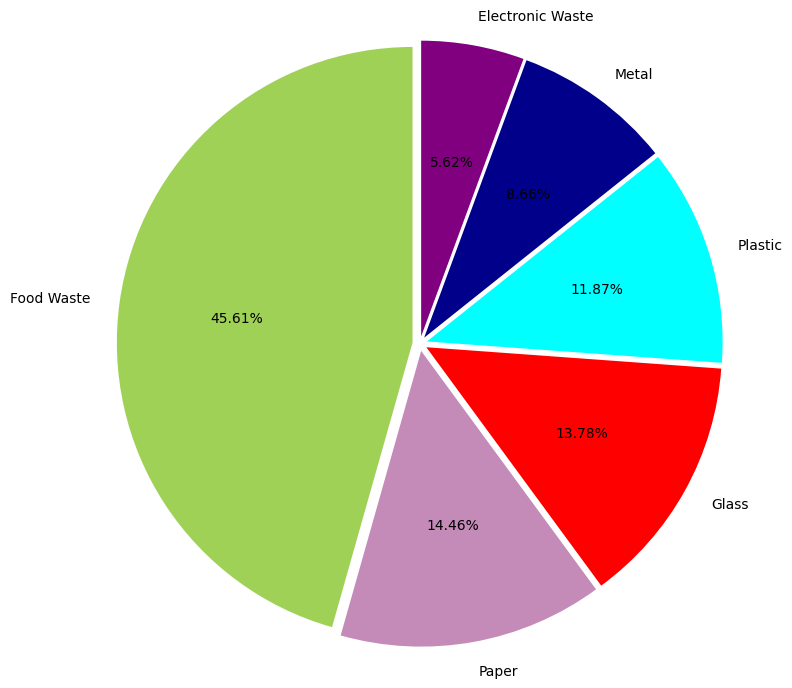

In [ ]:
colors = ['#a0d157','#c48bb8','#FF0000','#00FFFF','#00008B','#800080']
plt.pie(data.label.value_counts(),startangle=90,explode=[0.05,0.05,0.05,0.05,0.05,0.05],autopct='%0.2f%%',
        labels=['Food Waste','Paper','Glass','Plastic','Metal','Electronic Waste'], colors= colors,radius=2)
plt.show()

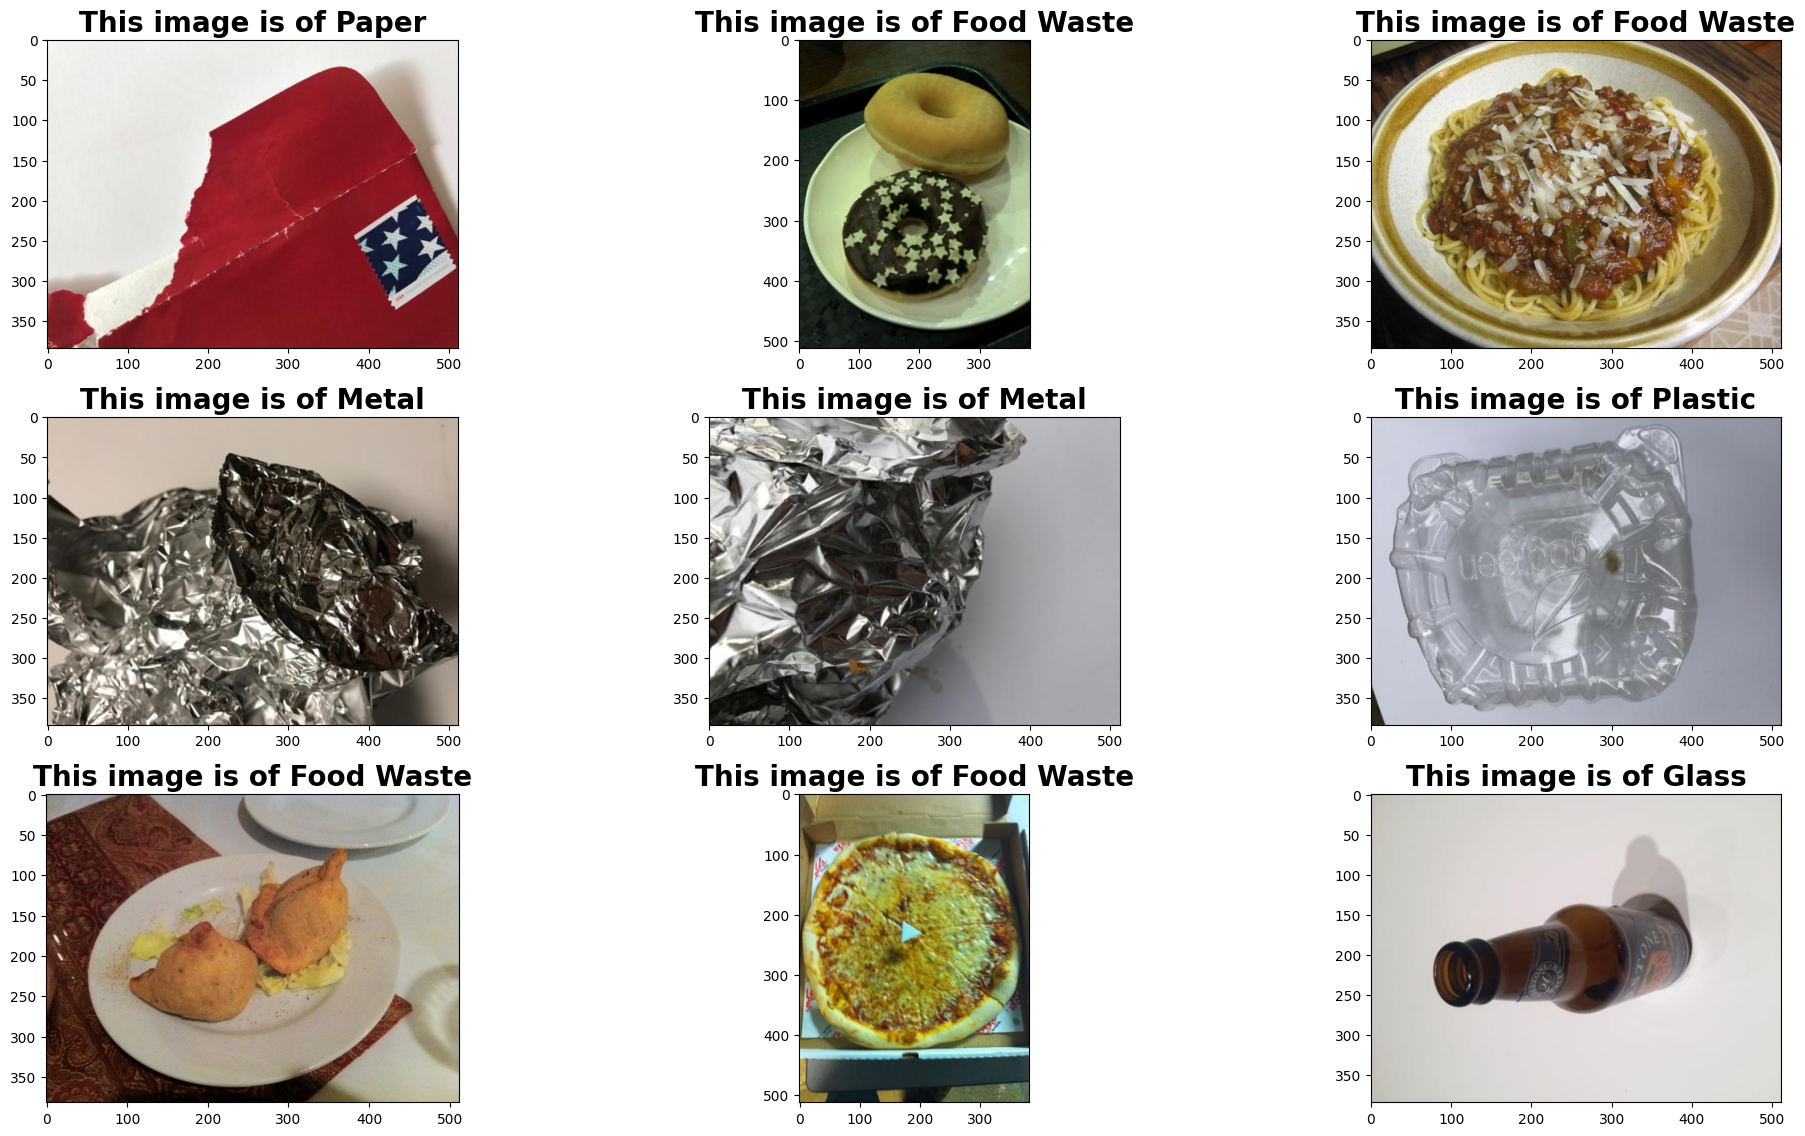

In [ ]:
plt.figure(figsize=(20,15))
for i in range(9):
    plt.subplot(4, 3, (i % 12) + 1)
    index = np.random.randint(len(data))
    if index >= len(data):
        print(f"Error: Index {index} is out of range.")
        break
    
    plt.title('This image is of {0}'.format(data.label[index]), fontdict={'size': 20, 'weight': 'bold'})
    plt.imshow(data.image[index])
    plt.tight_layout()

In [ ]:
class_names = glob.glob(train_path + '/*')
number_of_classes = len(class_names)
print("Number of Classes:", number_of_classes)

Number of Classes: 6


# Image and Batch size

In [ ]:
# Set the image size and batch size
img_size = (224, 224)
batch_size = 32

# Convolutional Neural Network - CNN

# Model 1

In [ ]:
# Create the CNN model
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=6, activation='softmax'))  # Use 7 units for 6 classes

# Define the learning rate scheduler
""""def lr_scheduler(epoch):
    initial_lr = 0.001
    drop = 0.1
    epochs_drop = 5
    lr = initial_lr * np.power(drop, np.floor((1 + epoch) / epochs_drop))
    return lr"""

#lr_callback = LearningRateScheduler(lr_scheduler)

# Compile the model with categorical_crossentropy loss for multi-class classification, weighted loss and metrics
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

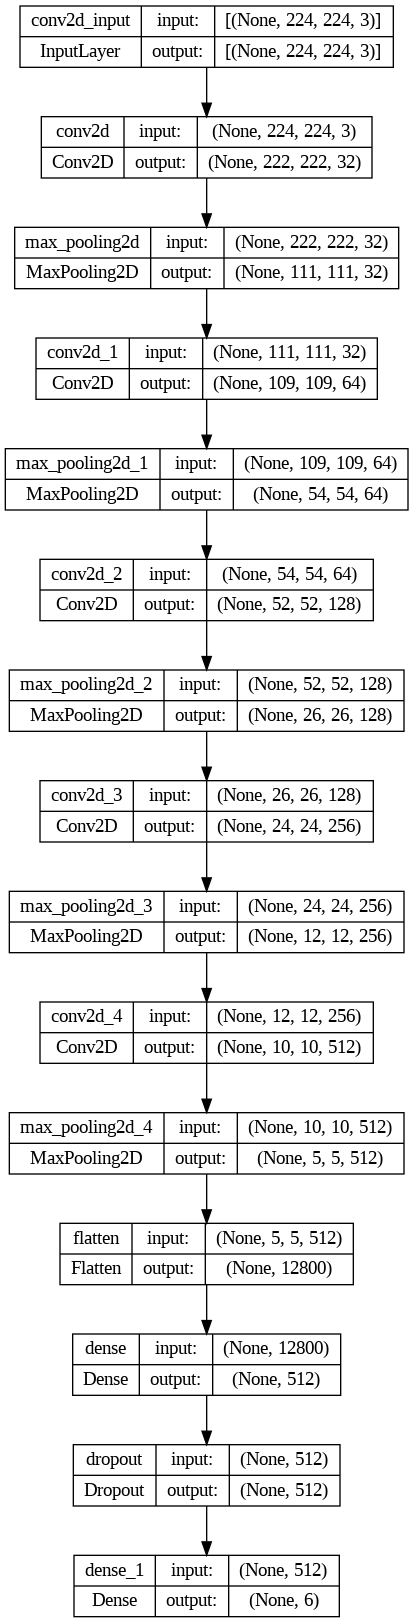

In [ ]:
# Generate the architecture figure
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Image Augmentation


In [ ]:
# Data augmentation for training images
train_datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False
)

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Load and preprocess the training data
train_data = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Load and preprocess the testing data
test_data = test_datagen.flow_from_directory(
    test_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

print(train_data.class_indices)
print(test_data.class_indices)

Found 3361 images belonging to 6 classes.
Found 1133 images belonging to 6 classes.
{'Electronic Waste': 0, 'Food Waste': 1, 'Glass': 2, 'Metal': 3, 'Paper': 4, 'Plastic': 5}
{'Electronic Waste': 0, 'Food Waste': 1, 'Glass': 2, 'Metal': 3, 'Paper': 4, 'Plastic': 5}


# Model Training

In [ ]:
#learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
# Train the model
hist = model.fit(
    train_data,
    steps_per_epoch=train_data.samples // batch_size,
    epochs=82,
    validation_data=test_data ,
    validation_steps=test_data .samples // batch_size,
    #callbacks = [learning_rate_reduction]
)

Epoch 1/82
105/105 [==============================] - 576s 5s/step - loss: 1.2089 - accuracy: 0.5245 - val_loss: 0.7716 - val_accuracy: 0.6973
Epoch 2/82
105/105 [==============================] - 82s 779ms/step - loss: 0.9795 - accuracy: 0.6041 - val_loss: 0.8195 - val_accuracy: 0.6562
Epoch 3/82
105/105 [==============================] - 82s 781ms/step - loss: 0.9143 - accuracy: 0.6227 - val_loss: 0.7800 - val_accuracy: 0.6938
Epoch 4/82
105/105 [==============================] - 82s 777ms/step - loss: 0.8945 - accuracy: 0.6509 - val_loss: 0.6450 - val_accuracy: 0.7304
Epoch 5/82
105/105 [==============================] - 81s 776ms/step - loss: 0.8663 - accuracy: 0.6530 - val_loss: 0.7235 - val_accuracy: 0.7036
Epoch 6/82
105/105 [==============================] - 82s 784ms/step - loss: 0.8402 - accuracy: 0.6741 - val_loss: 0.5813 - val_accuracy: 0.7705
Epoch 7/82
105/105 [==============================] - 84s 804ms/step - loss: 0.8518 - accuracy: 0.6612 - val_loss: 0.7343 - val_accu

# Evaluate the model

In [ ]:
accuracy = hist.history['accuracy'][-1] * 100
loss = hist.history['loss'][-1] * 100

validation_accuracy = hist.history['val_accuracy'][-1] * 100
validation_loss = hist.history['val_loss'][-1] * 100

print("Train Accuracy: {:.2f}%".format(accuracy))
print("Train Loss: {:.2f}%".format(loss))
print("Validation Accuracy: {:.2f}%".format(validation_accuracy))
print("Validation Loss: {:.2f}%".format(validation_loss))

Train Accuracy: 91.59%
Train Loss: 22.91%
Validation Accuracy: 92.32%
Validation Loss: 26.82%


1/1 [==============================] - 1s 553ms/step


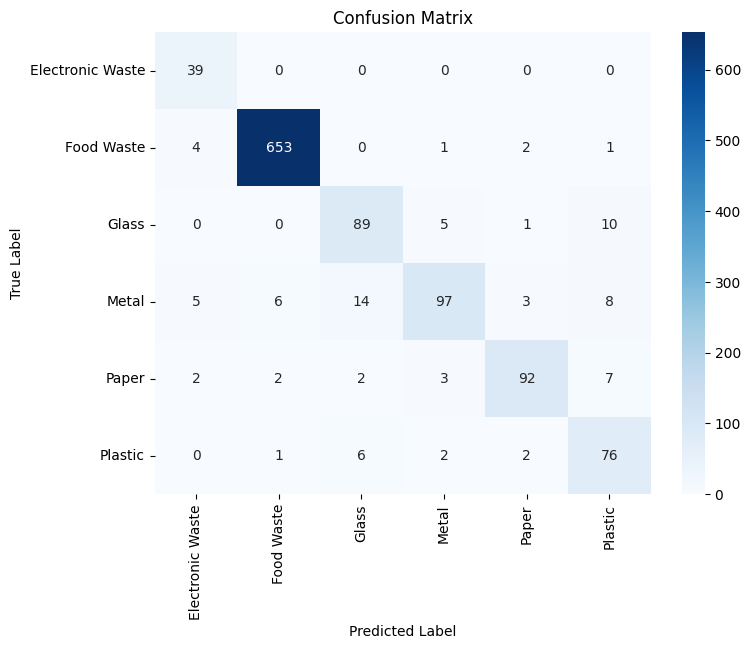


Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88        39
           1       0.99      0.99      0.99       661
           2       0.80      0.85      0.82       105
           3       0.90      0.73      0.80       133
           4       0.92      0.85      0.88       108
           5       0.75      0.87      0.80        87

    accuracy                           0.92      1133
   macro avg       0.86      0.88      0.86      1133
weighted avg       0.93      0.92      0.92      1133


F1 Score: 0.923021124467283


In [ ]:
# Evaluate the model
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, f1_score
test_steps = len(test_data)
y_true = []
y_pred = []

for i in range(test_steps):
    X_test, y_test = test_data[i]
    y_true.extend(np.argmax(y_test, axis=1))
    y_pred.extend(np.argmax(model.predict(X_test), axis=1))

# Convert the lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate the confusion matrix and classification report
cm = confusion_matrix(y_true, y_pred)
cr = classification_report(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')

# Plot the confusion matrix as a heatmap
class_names = test_data.class_indices.keys()
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print('\nClassification Report:')
print(cr)
print('\nF1 Score:', f1)

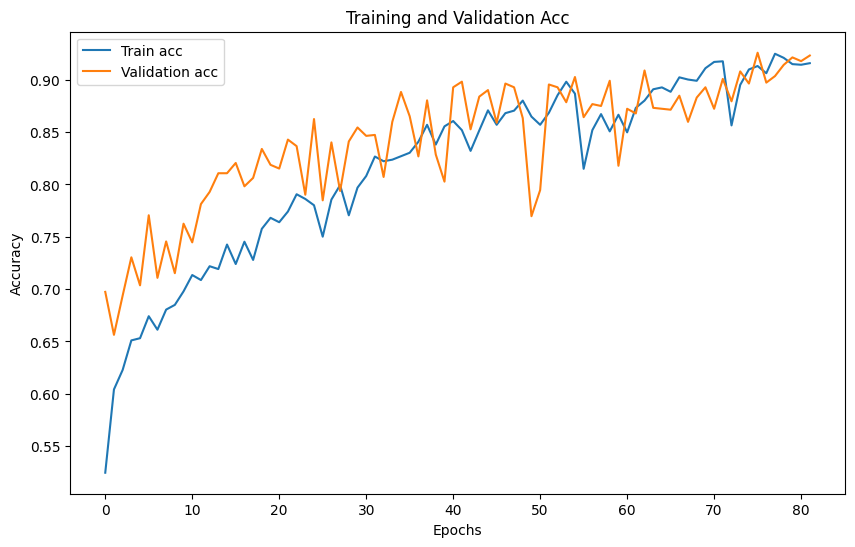

In [ ]:
plt.figure(figsize=[10,6])
plt.plot(hist.history["accuracy"], label="Train acc")
plt.plot(hist.history["val_accuracy"], label="Validation acc")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Acc')
plt.show()

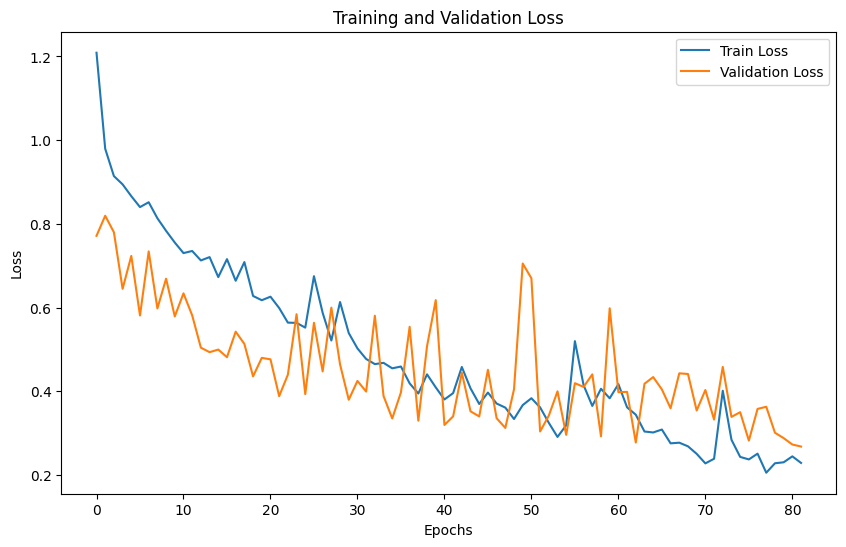

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.save("model4.h5")

# Model Prediction

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def predict_func(img): 
    plt.figure(figsize=(6, 4))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.tight_layout()
    
    img_resized = cv2.resize(img, (224, 224))
    img_normalized = img_resized / 255.0
    img_reshaped = np.reshape(img_normalized, [-1, 224, 224, 3])
    
    predictions = model.predict(img_reshaped)
    class_index = np.argmax(predictions)
    confidence = predictions[0][class_index]
    
    if class_index == 0:
        predicted_class = "Electronic Waste"
    elif class_index == 1:
        predicted_class = "Food Waste"
    elif class_index == 2:
        predicted_class = "Glass"
    elif class_index == 3:
        predicted_class = "Metal"
    elif class_index == 4:
        predicted_class = "Paper"    
    elif class_index == 5:
        predicted_class = "Plastic"       
    
    
    print("\033[94m" + "Predicted Class:", predicted_class + "\033[0m")
    print("\033[94m" + "Confidence:", confidence * 100, "%" + "\033[0m")


1/1 [==============================] - 0s 26ms/step
Predicted Class: Paper
Confidence: 92.66984462738037 %


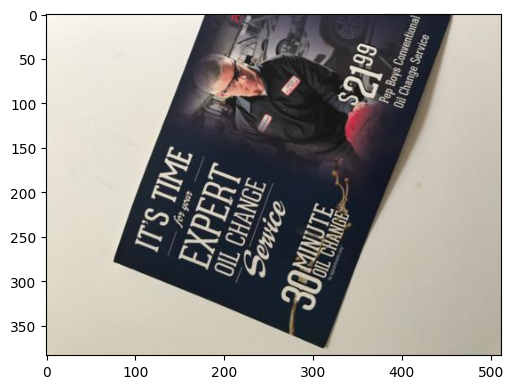

In [ ]:
test_img = cv2.imread("/content/drive/MyDrive/DATASET/TEST/Paper/paper452.jpg")
predict_func(test_img)

1/1 [==============================] - 0s 27ms/step
Predicted Class: Paper
Confidence: 99.73376393318176 %


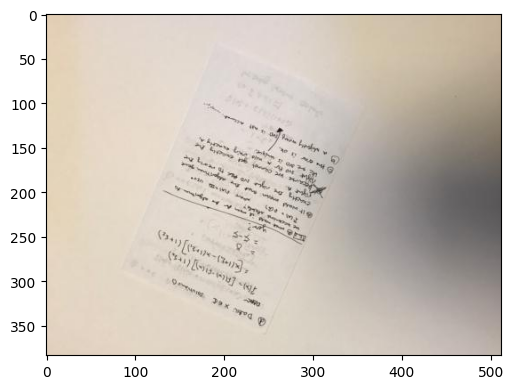

In [ ]:
test_img = cv2.imread("/content/drive/MyDrive/DATASET/TEST/Paper/paper431.jpg")
predict_func(test_img)

1/1 [==============================] - 0s 30ms/step
Predicted Class: Paper
Confidence: 48.36692214012146 %


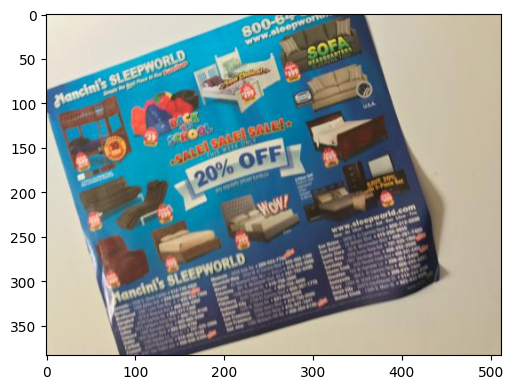

In [ ]:
test_img = cv2.imread("/content/drive/MyDrive/DATASET/TEST/Paper/paper408.jpg")
predict_func(test_img)

1/1 [==============================] - 0s 26ms/step
Predicted Class: Metal
Confidence: 95.62439322471619 %


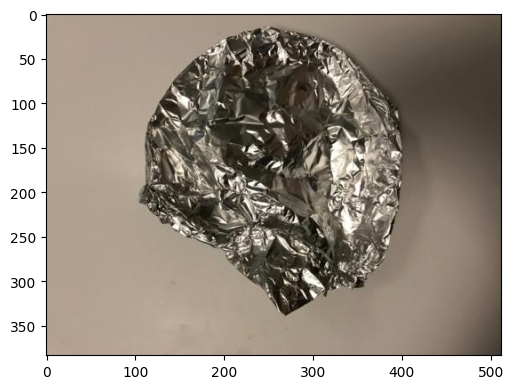

In [ ]:
test_img = cv2.imread("/content/drive/MyDrive/DATASET/TEST/Metal/metal266.jpg")
predict_func(test_img)

1/1 [==============================] - 0s 29ms/step
Predicted Class: Metal
Confidence: 98.80964756011963 %


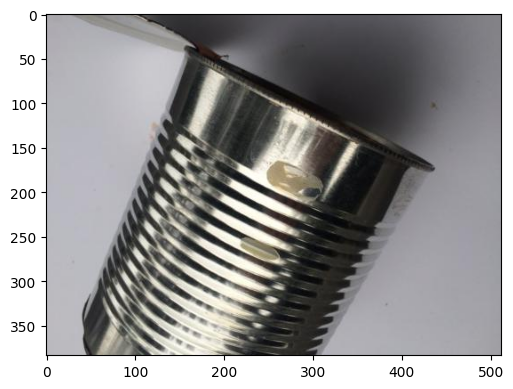

In [ ]:
test_img = cv2.imread("/content/drive/MyDrive/DATASET/TEST/Metal/metal236.jpg")
predict_func(test_img)

1/1 [==============================] - 0s 29ms/step
Predicted Class: Metal
Confidence: 79.95551228523254 %


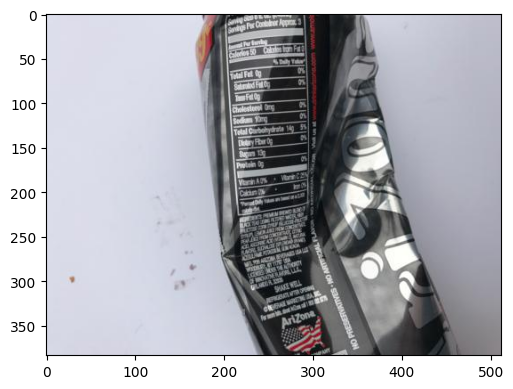

In [ ]:
test_img = cv2.imread("/content/drive/MyDrive/DATASET/TEST/Metal/metal273.jpg")
predict_func(test_img)

1/1 [==============================] - 0s 30ms/step
Predicted Class: Glass
Confidence: 87.40032315254211 %


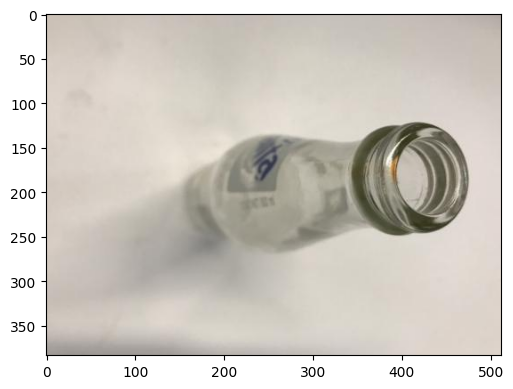

In [ ]:
test_img = cv2.imread("/content/drive/MyDrive/DATASET/TEST/Glass/glass172.jpg")
predict_func(test_img)

1/1 [==============================] - 0s 28ms/step
Predicted Class: Glass
Confidence: 99.98424053192139 %


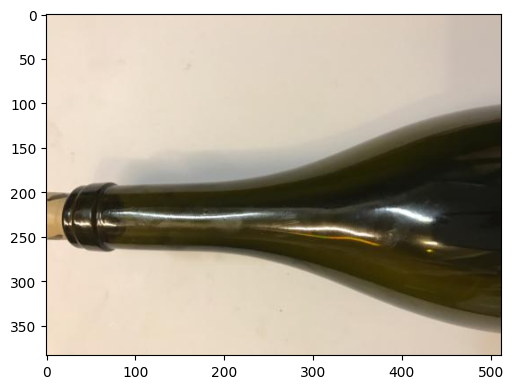

In [ ]:
test_img = cv2.imread("/content/drive/MyDrive/DATASET/TEST/Glass/glass143.jpg")
predict_func(test_img)

1/1 [==============================] - 0s 31ms/step
Predicted Class: Glass
Confidence: 65.70889949798584 %


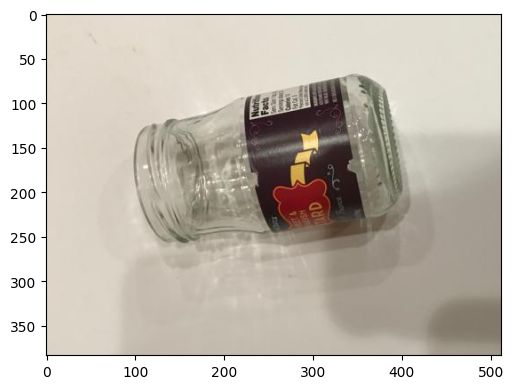

In [ ]:
test_img = cv2.imread("/content/drive/MyDrive/DATASET/TEST/Glass/glass135.jpg")
predict_func(test_img)

1/1 [==============================] - 0s 26ms/step
Predicted Class: Electronic Waste
Confidence: 100.0 %


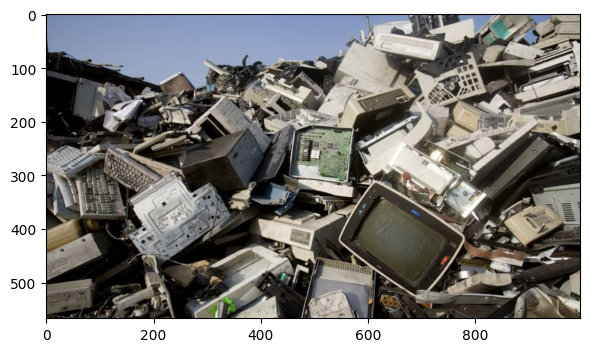

In [ ]:
test_img = cv2.imread("/content/drive/MyDrive/DATASET/TEST/Electronic Waste/Electronic waste (2).jpg")
predict_func(test_img)

1/1 [==============================] - 0s 27ms/step
Predicted Class: Electronic Waste
Confidence: 98.46353530883789 %


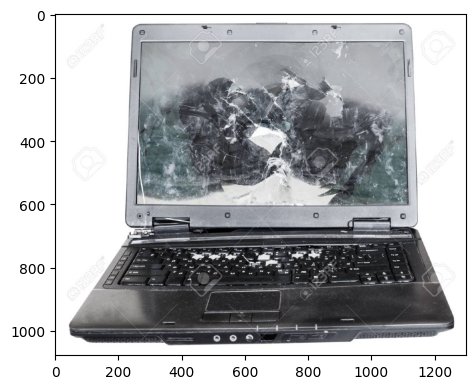

In [ ]:
test_img = cv2.imread("/content/drive/MyDrive/DATASET/TEST/Electronic Waste/Electronic waste (1).jpg")
predict_func(test_img)

1/1 [==============================] - 0s 26ms/step
Predicted Class: Electronic Waste
Confidence: 99.95511174201965 %


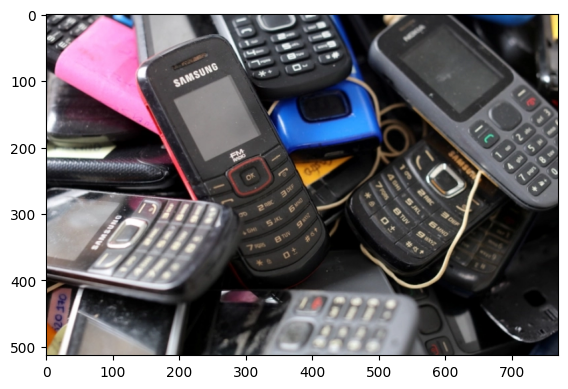

In [ ]:
test_img = cv2.imread("/content/drive/MyDrive/DATASET/TEST/Electronic Waste/Electronic waste (34).jpg")
predict_func(test_img)

1/1 [==============================] - 0s 26ms/step
Predicted Class: Plastic
Confidence: 99.99881982803345 %


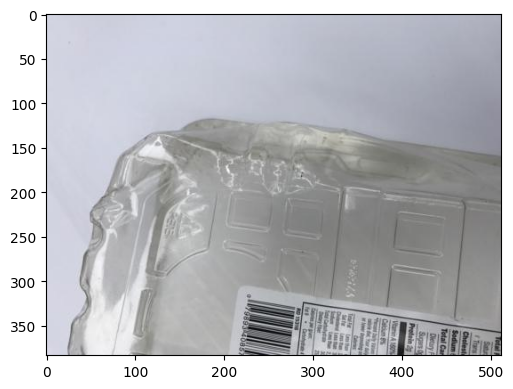

In [ ]:
test_img = cv2.imread("/content/drive/MyDrive/DATASET/TEST/Plastic/plastic (45).jpg")
predict_func(test_img)

1/1 [==============================] - 0s 28ms/step
Predicted Class: Plastic
Confidence: 99.89641904830933 %


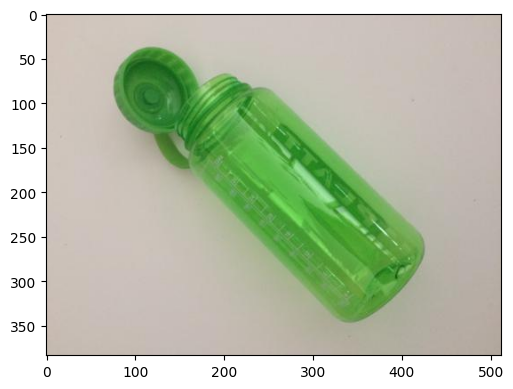

In [ ]:
test_img = cv2.imread("/content/drive/MyDrive/DATASET/TEST/Plastic/plastic (5).jpg")
predict_func(test_img)

1/1 [==============================] - 0s 31ms/step
Predicted Class: Plastic
Confidence: 98.7900972366333 %


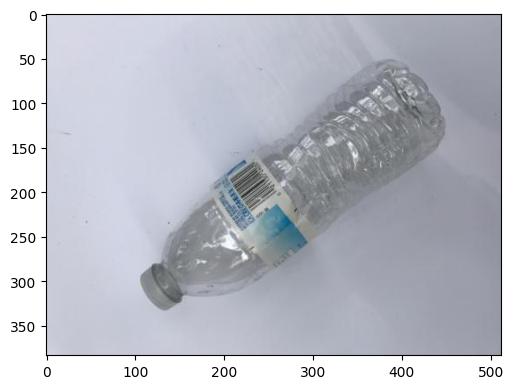

In [ ]:
test_img = cv2.imread("/content/drive/MyDrive/DATASET/TEST/Plastic/plastic (48).jpg")
predict_func(test_img)

1/1 [==============================] - 0s 73ms/step
Predicted Class: Food Waste
Confidence: 86.41525506973267 %


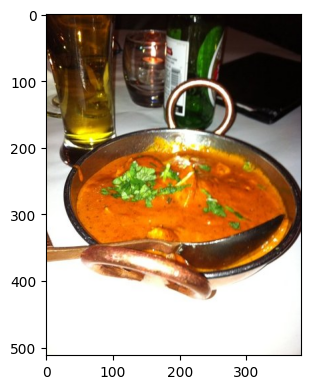

In [ ]:
test_img = cv2.imread("/content/drive/MyDrive/DATASET/TEST/Food Waste/Food waste (365).jpg")
predict_func(test_img)

1/1 [==============================] - 0s 69ms/step
Predicted Class: Food Waste
Confidence: 99.99943971633911 %


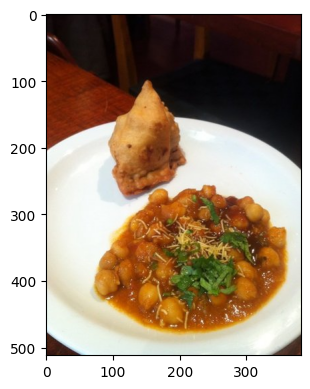

In [ ]:
test_img = cv2.imread("/content/drive/MyDrive/DATASET/TEST/Food Waste/Food waste (350).jpg")
predict_func(test_img)

1/1 [==============================] - 0s 31ms/step
Predicted Class: Food Waste
Confidence: 80.66507577896118 %


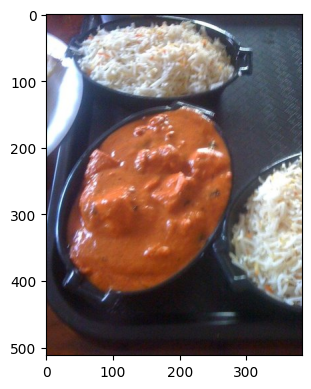

In [ ]:
test_img = cv2.imread("/content/drive/MyDrive/DATASET/TEST/Food Waste/Food waste (387).jpg")
predict_func(test_img)